# Comparing CHIRPS and URD Precipitation Data in Wyoming

 
In this demo we are comparing two historical precipitation datasets - __[CHIRPS](http://data.planetos.com/datasets/chg_chirps_global_05)__ and Unified Rain Gauge Data (__[URD](http://data.planetos.com/datasets/noaa_urd_conus)__)


Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) is a global **30+ year** gridded rainfall dataset using satellite and _in situ_ data with a resolution 0.05 degrees, while the Unified Raingauge dataset (URD) for the U.S. is a **60+ year** gridded analysis of precipitation using in _situ data_ with resolution of 0.25 degrees. 
Using these datasets you can analyse extreme events that occured in the past or identify long time precipitation trends.
Even though CHIRPS and URD have some differences, trends remain similar.


**In this demo we will**:

1) demonstrate the use of package API to fetch data;


2) show data from one point;


3) investigate data to:
    
    a. find the maximum precipitation over the entire period
    
    b. get average yearly values and compare them with time-series plot

    c. find out average number of dry days in both of the datasets

    d. get 95'th and 99'th percentiles for extreme event comparison
    
    e. compare average monthly values



In [1]:
%matplotlib notebook
import numpy as np
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from po_data_process import get_data_in_pandas_dataframe, make_plot,get_comparison_graph
import dh_py_access.package_api as package_api
import matplotlib.gridspec as gridspec
import calendar
import warnings
warnings.filterwarnings("ignore")

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

We need to define the dataset names as well as the spatial and temporal ranges. Please note that the datasets have different time ranges. At first, we will download as much data as possible. 

In [3]:
dh=datahub.datahub(server,version,API_key)
dataset1='noaa_urd_conus'
variable_name1 = 'precip'
dataset2='chg_chirps_global_05'
variable_name2 = variable_name1
time_start = '1948-01-01T00:00:00'
time_end = '2017-10-16T00:00:00'

In [4]:
area_name = 'Wyoming'
latitude_north = 45.05; longitude_west = -111.11
latitude_south = 41.00; longitude_east = -104.02

## Download the data with package API
1. Create package objects
2. Send commands for the package creation
3. Download the package files

_Note that those packages both have over 30 years of data and downloading them might take some time_

In [5]:
package_noaa_urd_conus=package_api.package_api(dh,dataset1,variable_name1,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,area_name=area_name)
package_chg_chirps_global_05=package_api.package_api(dh,dataset2,variable_name2,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,area_name=area_name)

In [6]:
package_noaa_urd_conus.make_package()

Package exists


In [7]:
package_chg_chirps_global_05.make_package()

Package exists


In [8]:
package_noaa_urd_conus.download_package()
package_chg_chirps_global_05.download_package()

File already downloaded
File already downloaded


## Work with downloaded files
1. Open files with xarray
2. Plot downloaded area and show orography on the background
3. Compute some interesting statistics for the dataset comparison

In [9]:
dd1 = xr.open_dataset(package_noaa_urd_conus.local_file_name)
dd2 = xr.open_dataset(package_chg_chirps_global_05.local_file_name)

Here you can see the total precipitation of Wyoming State over the past 36 years from CHIRPS data. It is as easy to test it with URD data. You just have to change dd2 to dd1 in the box below.

<IPython.core.display.Javascript object>


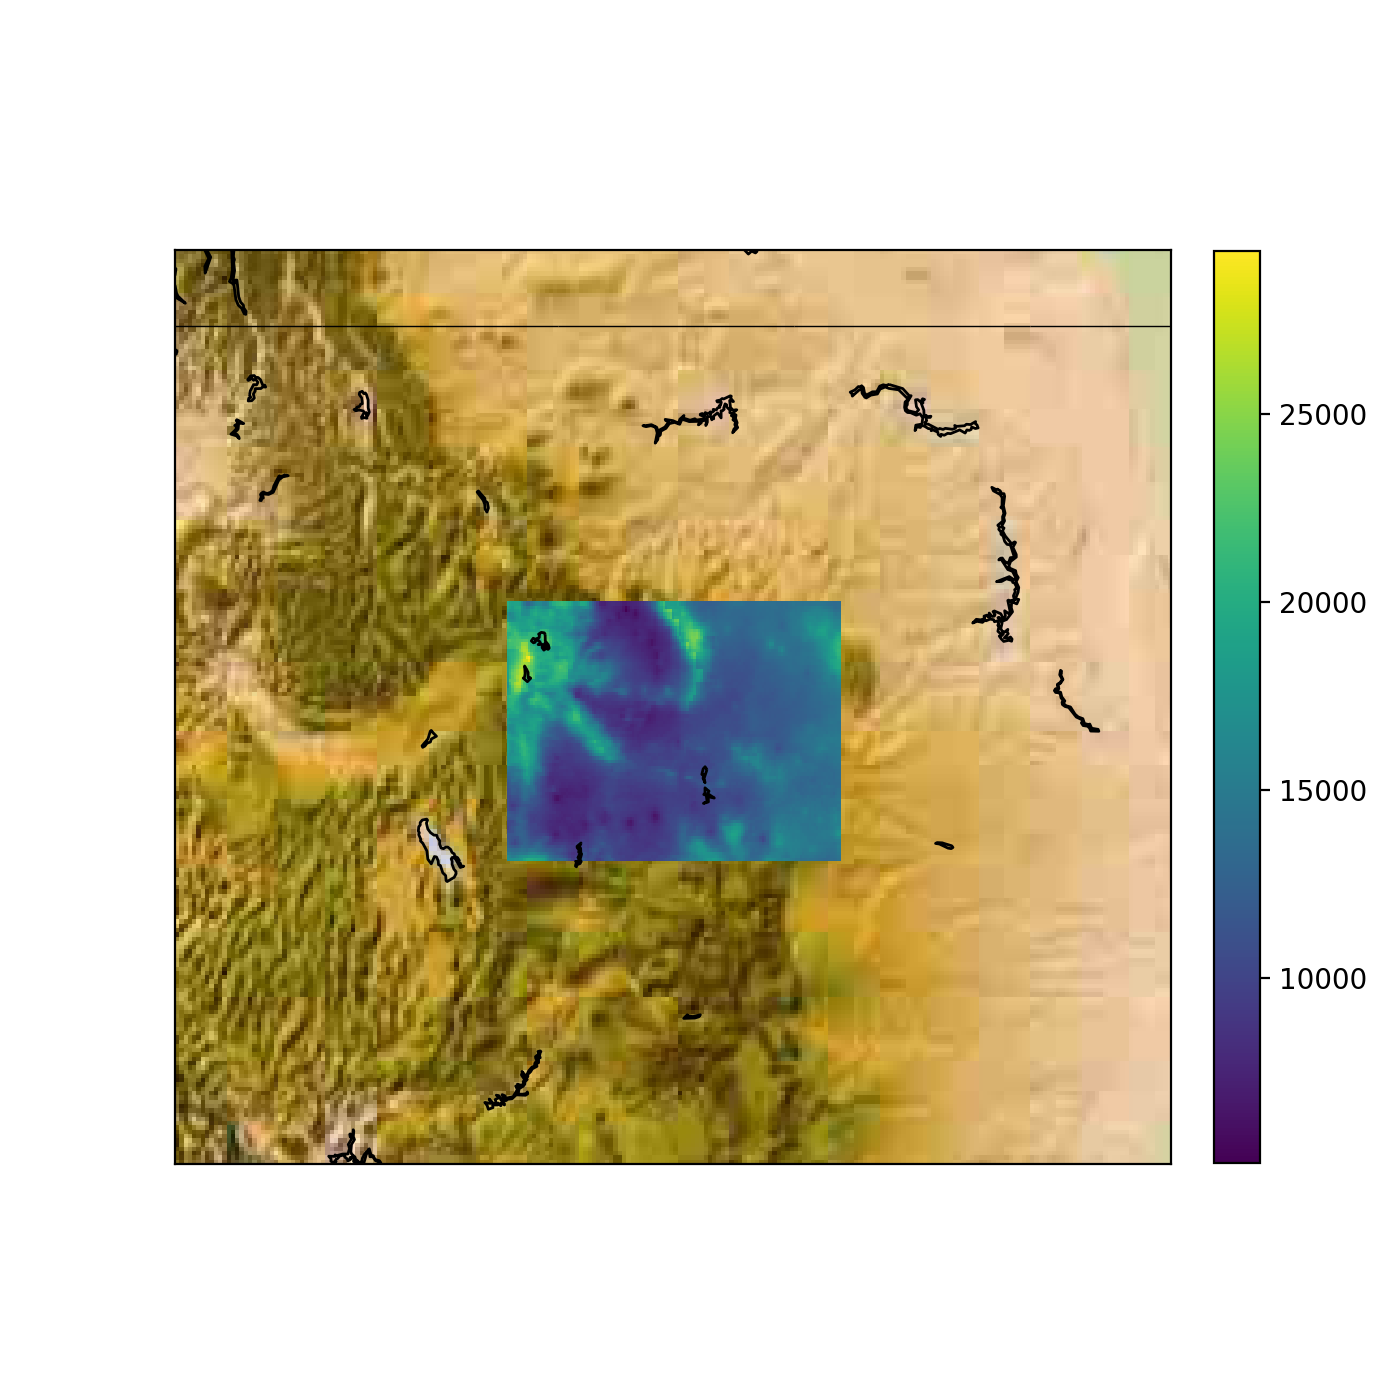

In [10]:
m_demo=Basemap(projection='merc',llcrnrlat=latitude_south-5,urcrnrlat=latitude_north+5,\
            llcrnrlon=longitude_west-7,urcrnrlon=longitude_east+7,lat_ts=(latitude_north+latitude_south)/2,resolution='i')
Dx,Dy = np.meshgrid(dd2.longitude.data,dd2.latitude.data)
dx,dy = m_demo(Dx,Dy)
fig=plt.figure(figsize=(7,7))
m_demo.pcolormesh(dx,dy,np.sum(dd2.precip.data[:,:,:],axis=0))
plt.colorbar(fraction=0.042, pad=0.04)
m_demo.drawcoastlines()
m_demo.drawcountries()
m_demo.etopo()

plt.show()

### Basic statistics 
We try to compute the following simple statistics with distributions inside the small domain where possible, and compare the values from the two datasets against each other.
1. Average yearly values
2. Number of dry days 
3. Number of days with precipitation over 10 mm
4. 95'th and 99'th percentiles
5. Average monthly values



We metioned that you should note the difference in time ranges. Let's see why.

<IPython.core.display.Javascript object>


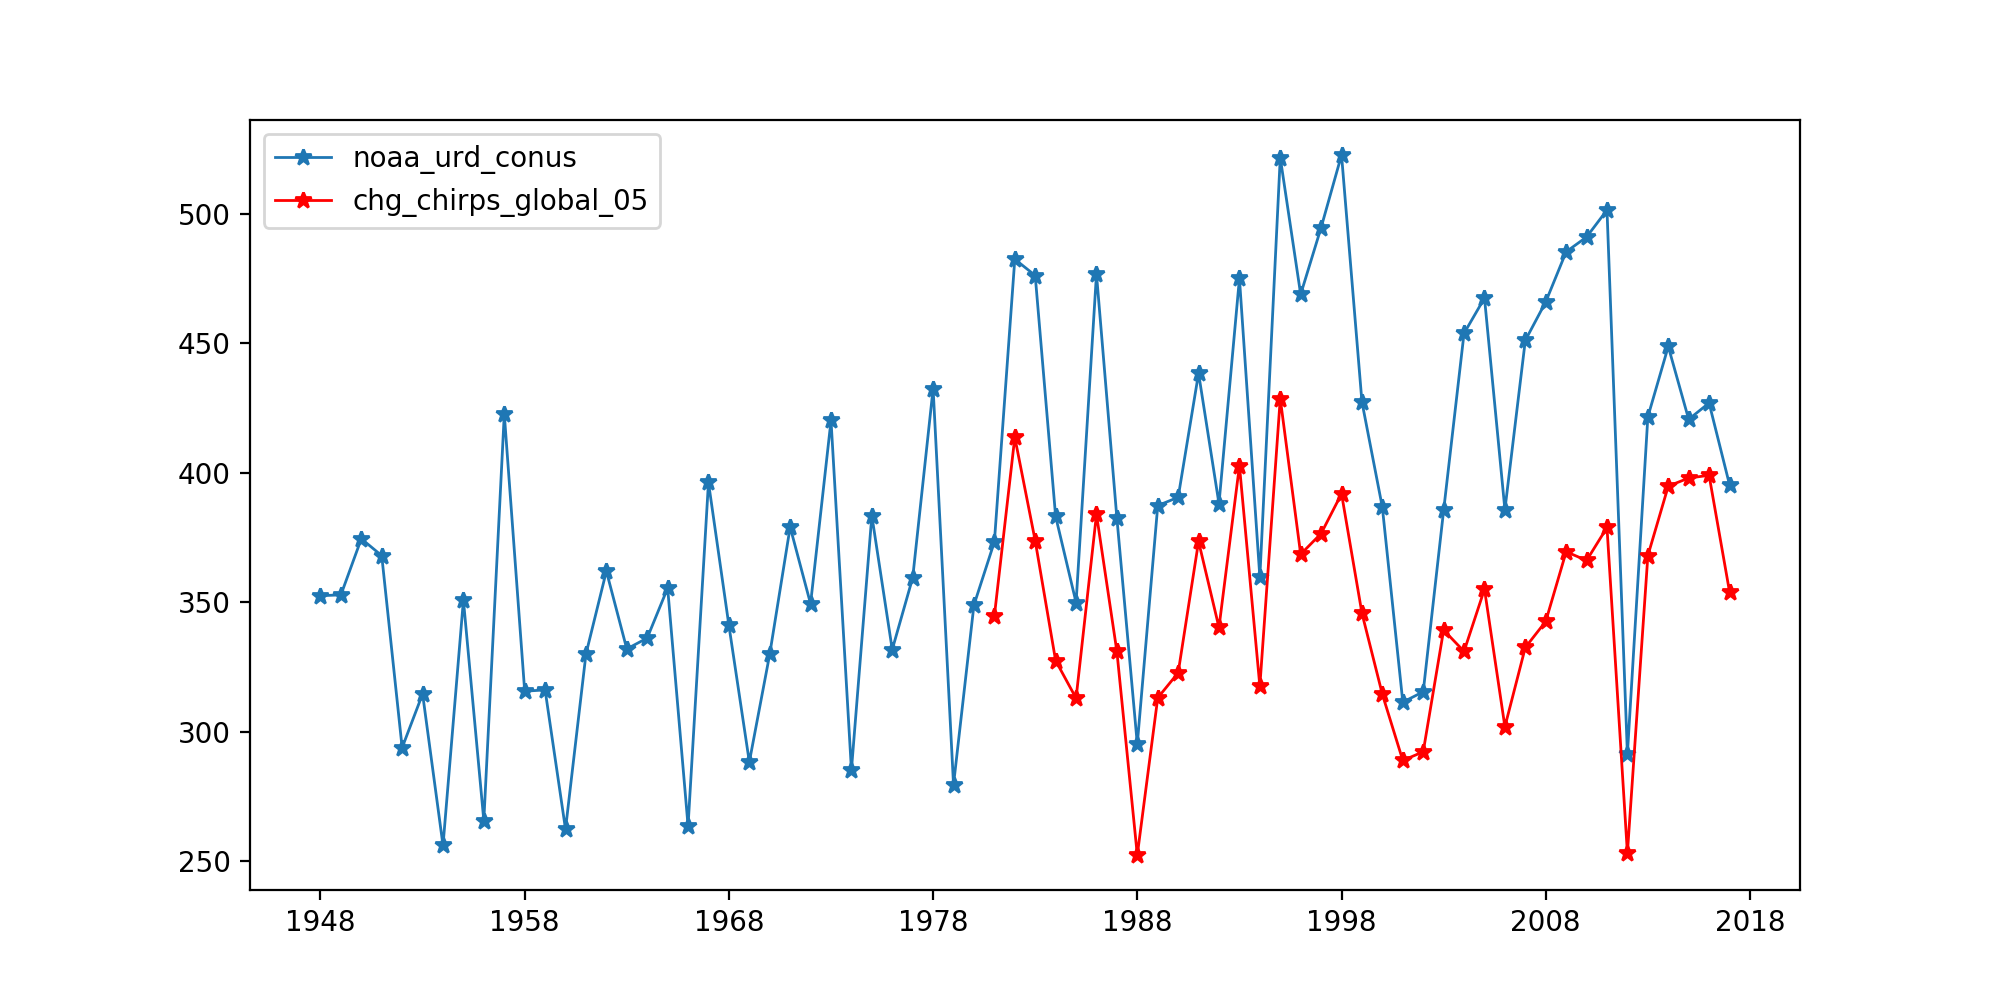

In [11]:
yearly_sum1 = dd1.precip.resample('1AS', dim='time', how='sum')
yearly_mean_sum1 = yearly_sum1.mean(axis=(1,2))

yearly_sum2 = dd2.precip.resample('1AS', dim='time', how='sum')
yearly_mean_sum2 = yearly_sum2.mean(axis=(1,2))



fig = plt.figure(figsize=(10,5))
plt.plot(yearly_mean_sum1.time,yearly_mean_sum1, '*-',linewidth = 1,label = dataset1)  
plt.plot(yearly_mean_sum2.time,yearly_mean_sum2, '*-',linewidth = 1,c='red',label = dataset2)
plt.legend()
plt.show()


In the plot above we can see that the __[URD](http://data.planetos.com/datasets/noaa_urd_conus)__ dataset temporal extent goes back to 1948, whereas the __[CHIRPS](http://data.planetos.com/datasets/chg_chirps_global_05)__ starts from 1981. As we want to compare the two datasets, we want the URD data to start from 1981 as well. 

In [12]:
time_start = '1981-01-01T00:00:00'

dd1 = dd1.sel(time = slice(time_start,time_end))
dd1_dat = np.ma.masked_where(np.isnan(dd1.precip.data),dd1.precip.data)
dd1['lon'] = ((dd1.lon+180) % 360) - 180
dd2_dat = dd2.precip.data


Now we look into the maximum precipitation of the entire period. We can see that the URD is getting bigger values and in our last plot, we also saw that the URD data had bigger values.

In [13]:
# maximum precipitation over the whole period
print ('\033[1mMaximum precipitation over the whole period \033[0m')
print(dataset1 + '\t\t' + str(np.nanmax(dd1_dat)))
print(dataset2 + '\t' + str(np.nanmax(dd2_dat)))

Maximum precipitation over the whole period 
noaa_urd_conus		159.3228302
chg_chirps_global_05	102.347854614


Below you can see the minimum, maximum and the average number of dry days. As we can see, the number of dry days is larger in the CHIRPS dataset. This can in part be explained by the resolution difference, i.e. one observation influences larger area in lower resolution grid. However, the difference 3000 vs 9000 dry days over the 36 year period is still pretty big and it requires some special attention when making the statistics using these datasets.

In [14]:
dd1_dry_days = np.sum(np.where(dd1_dat>0.1,0,1),axis=0)
dd2_dry_days = np.sum(np.where(dd2_dat>0.1,0,1),axis=0)

# minimum, maximum and average nr of dry days
print ('\033[1mNumber of dry days:\tMinimum\t Maximum Average\033[0m')
print(dataset1 + '\t\t' + str(np.amin(dd1_dry_days)), '\t',str(np.amax(dd1_dry_days)),'\t',str(np.mean(dd1_dry_days)))
print(dataset2 + '\t' + str(np.amin(dd2_dry_days)),'\t',str(np.amax(dd2_dry_days)),'\t',str(np.mean(dd2_dry_days)))

Number of dry days:	Minimum	 Maximum Average
noaa_urd_conus		3011 	 10421 	 7350.58035714
chg_chirps_global_05	9733 	 11031 	 10435.3363763


Now we are making a plot of the average number of dry days over the grid. In the plot we can see similar result with the last table. CHIRPS dataset has more dry days than the URD. And because of the resolution differences CHIRPS is smoother. 

<IPython.core.display.Javascript object>


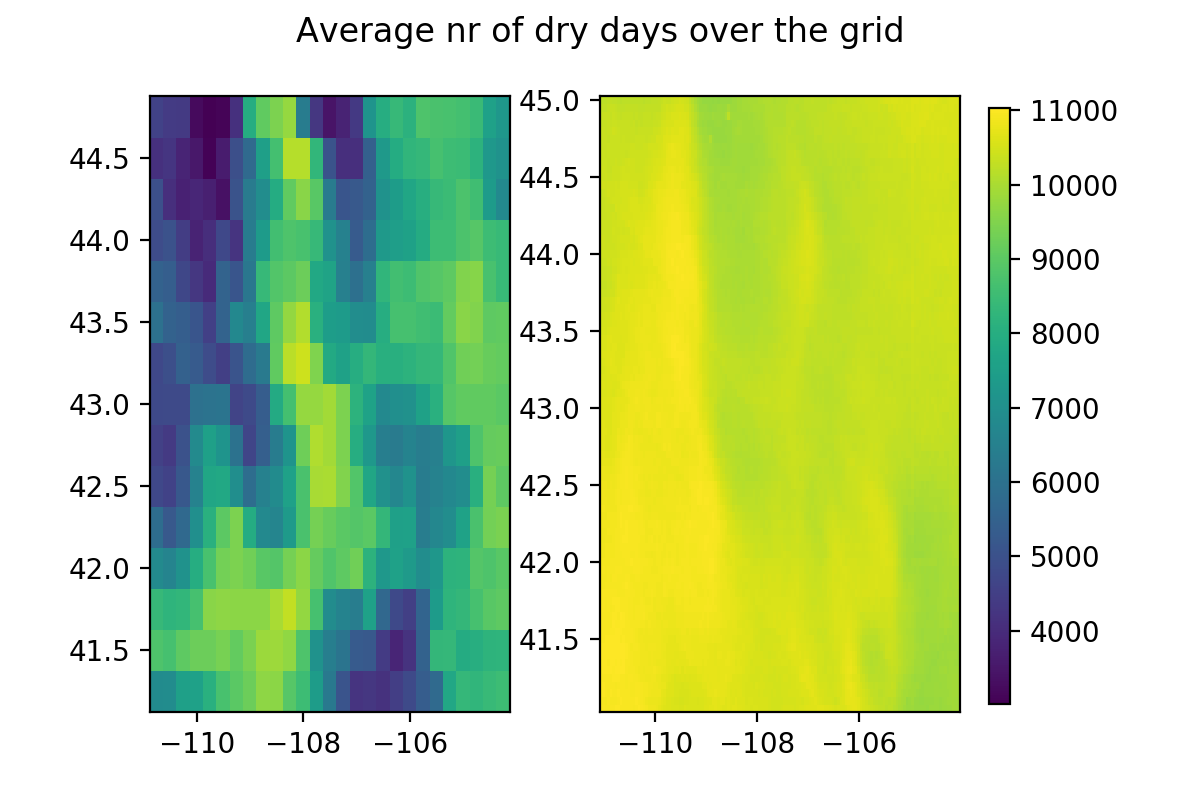

In [15]:
#average nr of dry days over the grid
get_comparison_graph(dd1.lon,dd1.lat,dd1_dry_days,dd2.longitude,dd2.latitude,dd2_dry_days,'Average nr of dry days over the grid')

## Percentiles

In this section we are going to compute percentiles the 99 percentiles and 95 percentiles.

In [16]:
dd1_25=np.nanpercentile(dd1_dat,25,axis=0)
dd1_95=np.nanpercentile(dd1_dat,95,axis=0)
dd1_99=np.nanpercentile(dd1_dat,99,axis=0)
dd1_999=np.nanpercentile(dd1_dat,99.9,axis=0)
dd2_25=np.nanpercentile(dd2_dat,25,axis=0)
dd2_95=np.percentile(dd2_dat,95,axis=0)
dd2_99=np.percentile(dd2_dat,99,axis=0)
dd2_999=np.nanpercentile(dd2_dat,99.9,axis=0)

In the box above we got 99 and 95 percentiles for both datasets and we are now making a comparison plot about 99 percetiles. Plot shows the distribution of 99 percentiles. We can see some similarities between the plots, however, different resolution makes it hard to compare. 99 percentiles are showing distribution of heavy precipitation. For example, 25 in the plot means that only on 1 % of cases there has been more daily precipitation than 25 mm.  

<IPython.core.display.Javascript object>


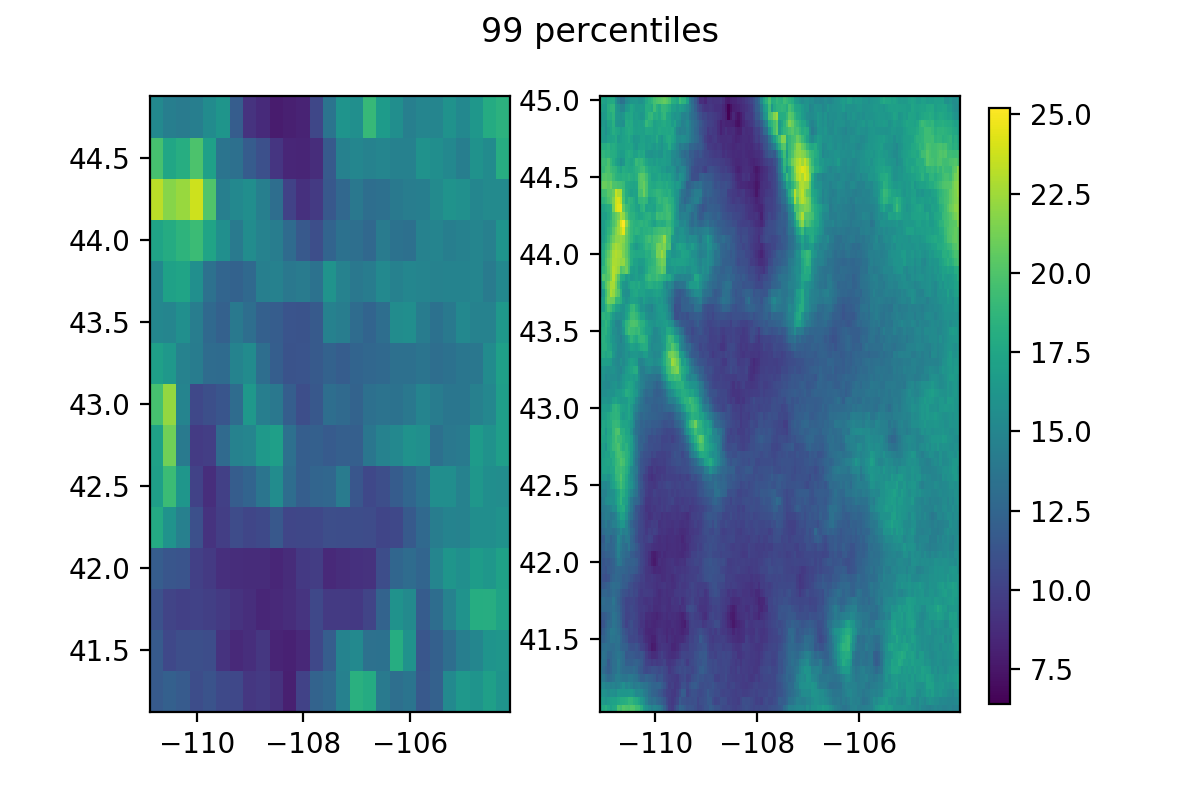

In [17]:
get_comparison_graph(dd1.lon,dd1.lat,dd1_99,dd2.longitude,dd2.latitude,dd2_99,'99 percentiles')

However, when we look at the averages of the precentiles, we can see that statistically the distribution of stronger precipitation is similar for all three, 5% of the strongest, 1% of the strongest and 0.1% of the strongest daily precipitations.

In [18]:
## Average precentiles
print('Percentiles \t', dataset1, '\t', dataset2)
print('Percentile 25\t',np.mean(dd1_25),'\t',np.mean(dd2_25))
print('Percentile 95\t',np.mean(dd1_95),'\t\t',np.mean(dd2_95))
print('Percentile 99\t',np.mean(dd1_99),'\t\t',np.mean(dd2_99))
print('Percentile 99.9\t',np.mean(dd1_999),'\t\t',np.mean(dd2_999))

Percentiles 	 noaa_urd_conus 	 chg_chirps_global_05
Percentile 25	 0.00437020812959 	 0.0
Percentile 95	 5.73730923629 		 5.97073079994
Percentile 99	 13.6443914347 		 13.8525612112
Percentile 99.9	 28.6128536751 		 27.9406477105


## Monthly averages over the period

Finally, we are comparing monthly averages using the violin plot. 

In [19]:
##help(dd1.precip.resample)
dd1_monthly_avg = dd1.precip.resample('1MS', dim='time', how='sum')
dd2_monthly_avg = dd2.precip.resample('1MS', dim='time', how='sum')

In [20]:
mm_data1 = [];mm_data2 = []
for i in range(12):
    mmm1 = np.mean(dd1_monthly_avg[i::12,:,:],axis=0).values
    mm_data1.append(mmm1)
    mmm2 = np.mean(dd2_monthly_avg[i::12,:,:],axis=0).values
    mm_data2.append(mmm2)

In the violin plot below we can see minimum, maximum and mean monthly averages. Blue is referring to URD and orange to CHIRPS. We can see that CHIRPS dataset has smaller monthly values than the URD. However, on five months (April, July, August, September and October), CHIRPS has bigger maximum average precipitation values. URD average minimum values are also bigger than CHIRPS. We witnessed similar pattern in the plot where we made URD and CHIRPS timeseries with annual precipitation. 

<IPython.core.display.Javascript object>


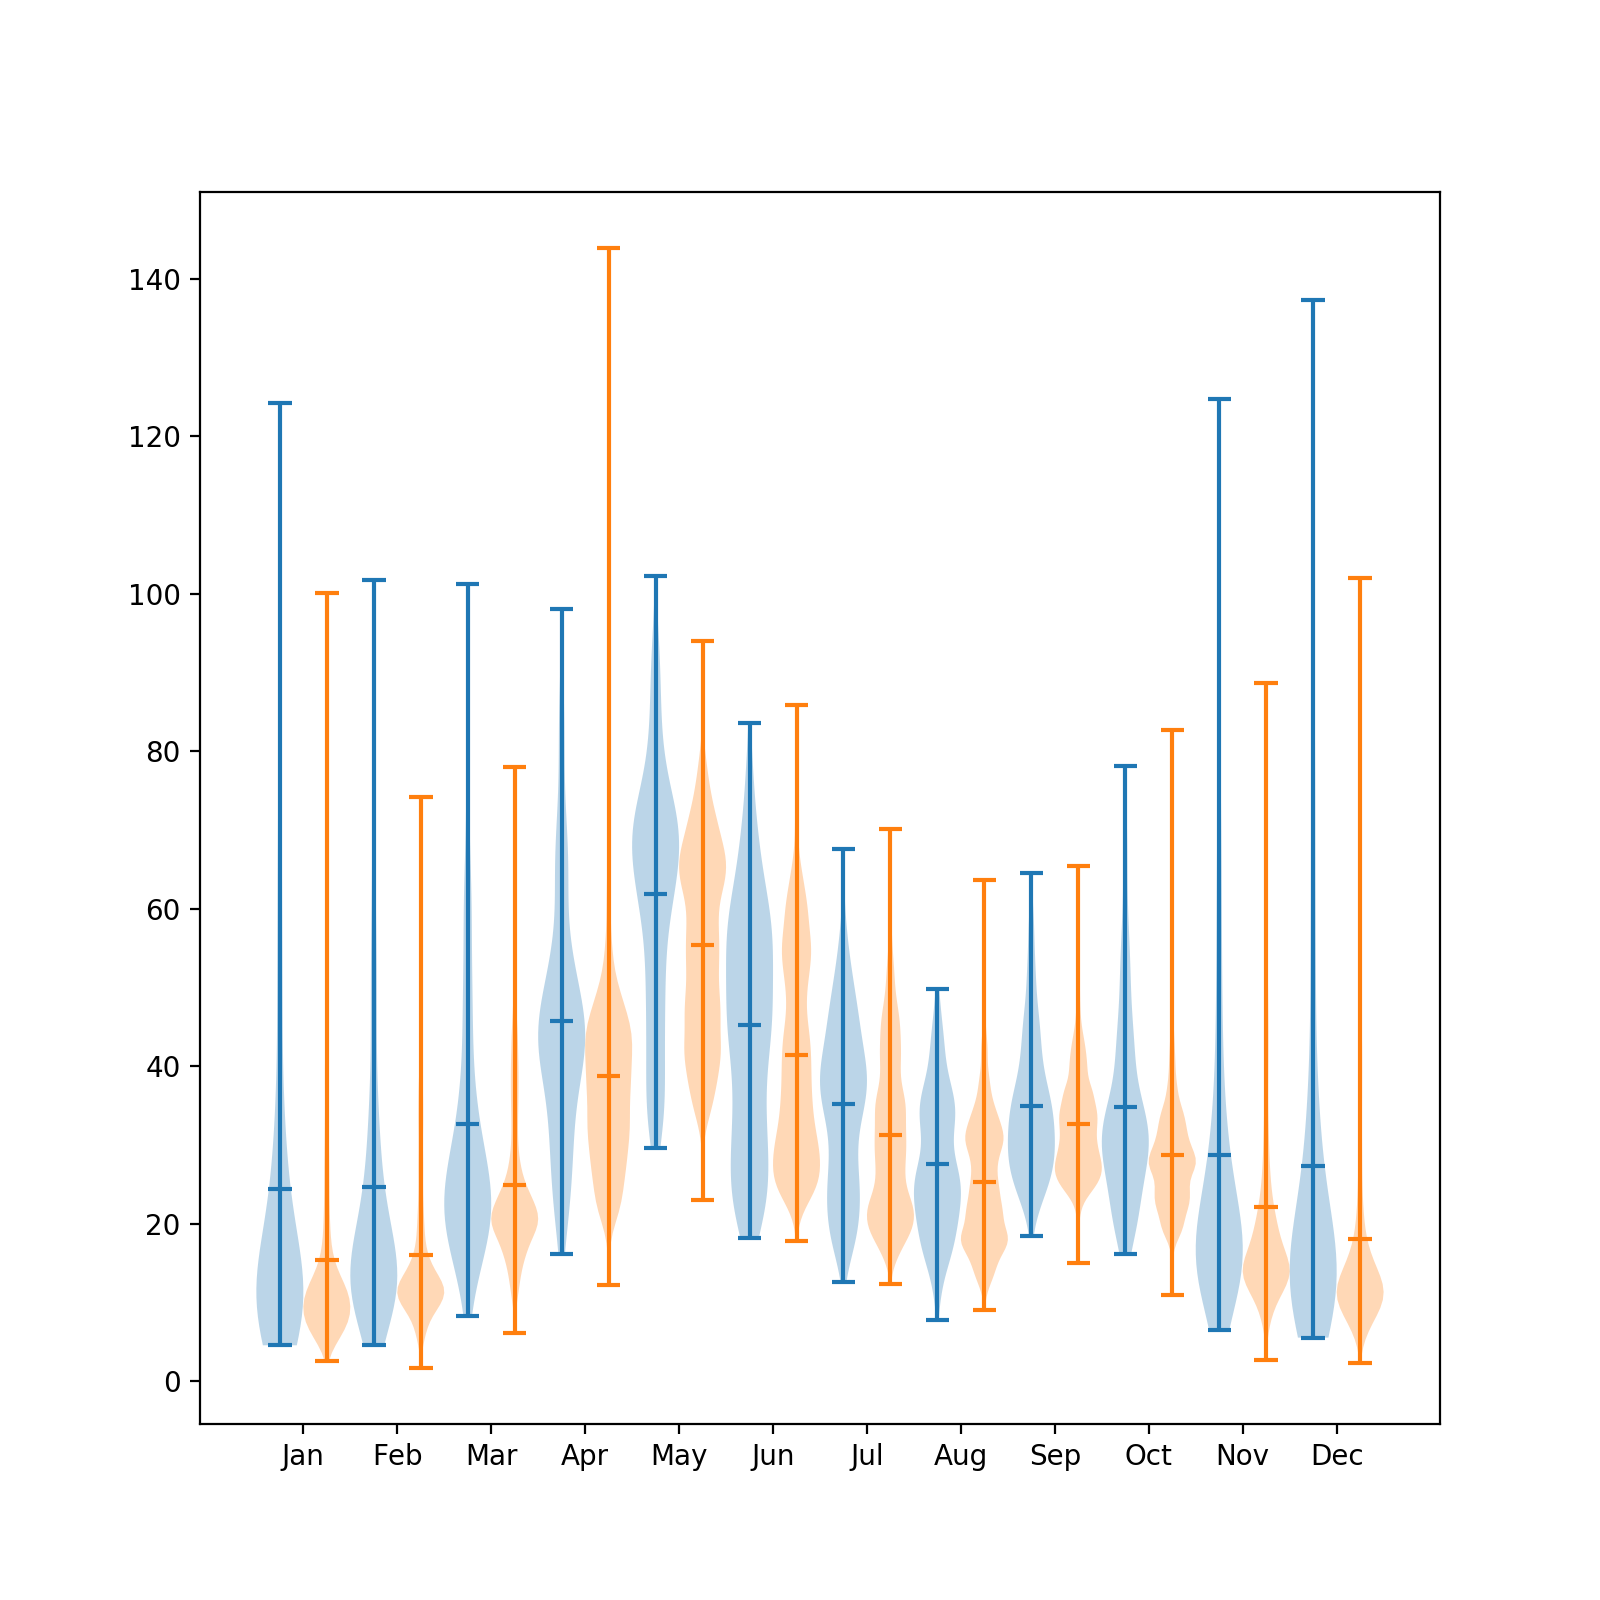

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.violinplot(mm_data1,np.arange(0.75,12.75,1),
                   showmeans=True,
                   showmedians=False)
ax.violinplot(mm_data2,np.arange(1.25,13.25,1),
                   showmeans=True,
                   showmedians=False)
plt.setp(ax, xticks = np.arange(1,13,1),
         xticklabels=[calendar.month_abbr[m] for m in np.arange(1,13,1)])

plt.show()